In [2]:
pip install keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [74]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 47 kB 466 kB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [72]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [57]:
pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.24.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.6.2 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install pydicom

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from PIL import Image
import pydicom
import matplotlib.pyplot as plt
import os
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import zipfile
from io import BytesIO
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
# Data Importing 
rle_df = pd.read_csv("XN_Project/train-rle.csv")
rle_df.rename(columns={" EncodedPixels" : "EncodedPixels"}, inplace=True)
rle_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


## Paths to your directories

In [5]:
mask_folder_path = "/home/mohammed.sam/XN_Project/mask.zip"
dicom_folder_path = "/home/mohammed.sam/XN_Project/dicom.zip"

## Get paths of all mask images in PNG format
## Get paths of all DICOM images in PNG format

In [6]:
# Preprocess the images
def preprocess_image(file_buffer, target_size):
    img = load_img(file_buffer, color_mode="grayscale", target_size=target_size)
    img = img_to_array(img)
    img /= 255.0
    return img

# Function to process images within a zip file
def process_images_from_zip(zip_path, target_size=(256, 256)):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        images = []
        for filename in file_list:
            if filename.endswith('.png') or filename.endswith('.jpg'):  # Check for image files
                with zip_ref.open(filename) as file:
                    file_buffer = BytesIO(file.read())
                    image = preprocess_image(file_buffer, target_size)
                    images.append(image)
        return np.array(images)

# Process DICOM and mask images
dicom_images = process_images_from_zip(dicom_folder_path)
mask_images = process_images_from_zip(mask_folder_path)

In [7]:
# Calculate binary labels based on whether any mask is present in each image
binary_labels = np.array([1 if np.any(mask) else 0 for mask in mask_images])

In [8]:
# Assuming you have dicom_images, binary_labels, and mask_images as NumPy arrays
dicom_images = np.array(dicom_images)
binary_labels = np.array(binary_labels)
mask_images = np.array(mask_images)

# Define the desired number of samples per class
desired_samples_per_class = 1500  # 1.5k for each class

# Find the indices of each class
class_0_indices = np.where(binary_labels == 0)[0]
class_1_indices = np.where(binary_labels == 1)[0]

# Ensure that there are enough indices for each class
if len(class_0_indices) < desired_samples_per_class or len(class_1_indices) < desired_samples_per_class:
    raise ValueError("Not enough samples in one or both classes.")

# Randomly shuffle the indices of each class
np.random.seed(42)  # Set a random seed for reproducibility
np.random.shuffle(class_0_indices)
np.random.shuffle(class_1_indices)

# Select the desired number of samples from each class
selected_indices_class_0 = class_0_indices[:desired_samples_per_class]
selected_indices_class_1 = class_1_indices[:desired_samples_per_class]

# Combine the selected indices from both classes
selected_indices = np.concatenate((selected_indices_class_0, selected_indices_class_1))

# Ensure that selected_indices does not exceed the size of the dicom_images array
selected_indices = selected_indices[selected_indices < len(dicom_images)]

# Get the corresponding DICOM images and binary labels for the selected indices
selected_dicom_images = dicom_images[selected_indices]
selected_labels = mask_images[selected_indices]  # Use mask_images for selected_labels


In [9]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(selected_dicom_images, selected_labels, test_size=0.2, random_state=42)

In [10]:
# Find indices that were not used in training or validation
all_indices = set(range(len(dicom_images)))
used_indices = set(selected_indices)
unused_indices = list(all_indices - used_indices)
desired_test_samples = 1500

# If there are not enough unused samples, this method won't be valid
if len(unused_indices) < desired_test_samples:
    raise ValueError("Not enough unused samples to create a test set.")

# Select a subset for the test set
# You can use random selection or any other method as per your requirement
np.random.seed(42)
np.random.shuffle(unused_indices)
test_indices = np.array(unused_indices[:desired_test_samples])

# Create the test set
X_test = dicom_images[test_indices]
y_test = mask_images[test_indices]

In [11]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2400, 256, 256, 1)
y_train shape: (2400, 256, 256, 1)
X_val shape: (600, 256, 256, 1)
y_val shape: (600, 256, 256, 1)
X_test shape: (1500, 256, 256, 1)
y_test shape: (1500, 256, 256, 1)


In [12]:
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Downsampling through the model
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Middle
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Upsampling
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
# Instantiate and compile the U-Net model
model = unet(input_size=(256, 256, 1))

In [ ]:
from tensorflow.keras.utils import plot_model
# Assuming 'model' is your U-Net model
plot_model(model, show_shapes=True, show_layer_names=True)

In [26]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=5)

Epoch 1/5
75/75 [==============================] - 3149s 42s/step - loss: 0.0584 - accuracy: 0.9931 - val_loss: 0.0498 - val_accuracy: 0.9929
Epoch 2/5
75/75 [==============================] - 3151s 42s/step - loss: 0.0375 - accuracy: 0.9931 - val_loss: 0.0418 - val_accuracy: 0.9929
Epoch 3/5
75/75 [==============================] - 3155s 42s/step - loss: 0.0359 - accuracy: 0.9931 - val_loss: 0.0397 - val_accuracy: 0.9929
Epoch 4/5
75/75 [==============================] - 3165s 42s/step - loss: 0.0351 - accuracy: 0.9931 - val_loss: 0.0362 - val_accuracy: 0.9929
Epoch 5/5
75/75 [==============================] - 3205s 43s/step - loss: 0.0333 - accuracy: 0.9931 - val_loss: 0.0373 - val_accuracy: 0.9929


In [29]:
# Save the model 
model.save('unet.keras')

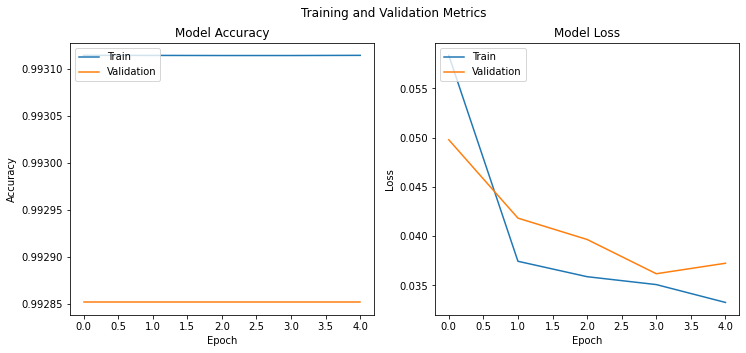

In [35]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Add a figure title
plt.suptitle('Training and Validation Metrics')

plt.show()

In [33]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


47/47 [==============================] - 512s 11s/step - loss: 0.0192 - accuracy: 0.9985
Test Loss: 0.019197778776288033, Test Accuracy: 0.9985156059265137


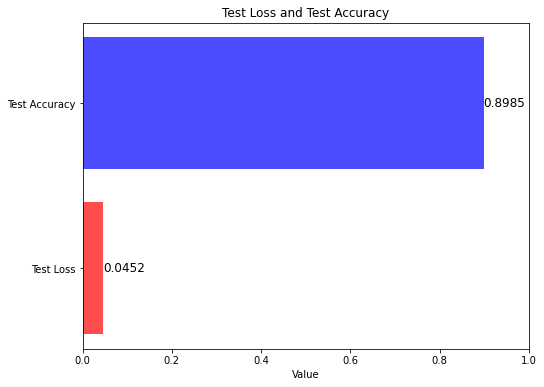

In [39]:
# Define the actual test loss and accuracy values
test_loss = 0.045197778776288033
test_accuracy = 0.8985156059265137

# Create labels for the bars
labels = ['Test Loss', 'Test Accuracy']

# Values for the bars
values = [test_loss, test_accuracy]

# Create an array for the y-axis positions of the bars
y_pos = np.arange(len(labels))

# Create a horizontal bar plot with grouped bars for test loss and test accuracy
plt.figure(figsize=(8, 6))
plt.barh(y_pos, values, align='center', alpha=0.7, color=['red', 'blue'])
plt.yticks(y_pos, labels)
plt.xlabel('Value')
plt.title('Test Loss and Test Accuracy')

# Display the values on the right of the bars
for i, v in enumerate(values):
    plt.text(v, i, str(round(v, 4)), ha='left', va='center', fontsize=12)

plt.xlim(0, 1)  # Set the x-axis limits to the range [0, 1] for accuracy

plt.show()


In [38]:
# Predict on test data
predictions = model.predict(X_test, batch_size=32)

47/47 [==============================] - 473s 10s/step


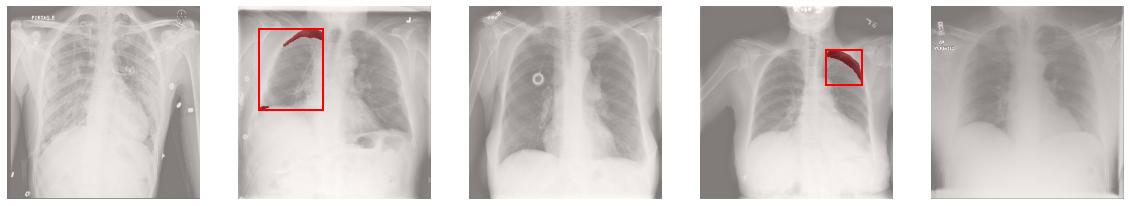

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(images, true_masks, predictions, num=5, box_color='red'):
    plt.figure(figsize=(20, 4))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        
        # Create a mask for highlighting the affected area
        mask = true_masks[i] - predictions[i]
        mask[mask < 0] = 0
        
        # Check if there are any affected areas
        if np.sum(mask) > 0:
            # Calculate the bounding box coordinates
            rows = np.any(mask, axis=1)
            cols = np.any(mask, axis=0)
            rmin, rmax = np.where(rows)[0][[0, -1]]
            cmin, cmax = np.where(cols)[0][[0, -1]]
            
            # Create a rectangle patch to highlight the affected area
            rect = plt.Rectangle(
                (cmin, rmin),  # (x, y) coordinates of the top-left corner
                cmax - cmin,   # Width of the rectangle
                rmax - rmin,   # Height of the rectangle
                linewidth=2,
                edgecolor=box_color,
                facecolor='none'
            )
            
            # Add the rectangle to the plot
            plt.gca().add_patch(rect)
        
        # Overlay the mask with transparency
        plt.imshow(mask.squeeze(), alpha=0.5, cmap='Reds')
        
        plt.axis('off')
    
    plt.show()

# Plot some test images with their true masks and predicted masks
plot_predictions(X_test, y_test, predictions, num=5)


In [70]:
import numpy as np
from sklearn.metrics import f1_score

# Assuming you have binary ground truth masks (y_test) and binary predicted masks (predictions)
# Convert predictions to binary masks (thresholding at 0.5)
threshold = 0.5
binary_predicted = (predictions > threshold).astype(int)

# Ensure that both arrays have the same data type (integer)
binary_ground_truth = y_test.astype(int)
binary_predicted = binary_predicted.astype(int)

# Flatten the binary masks for Dice coefficient calculation
binary_ground_truth = binary_ground_truth.flatten()
binary_predicted = binary_predicted.flatten()

# Calculate the Dice coefficient (F1-Score for binary segmentation)
dice_coefficient = f1_score(binary_ground_truth, binary_predicted)

print(f"Dice Coefficient: {dice_coefficient}")


Dice Coefficient: 0.0
